# Figure 1

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

cm = 1/2.54  # centimeters in inches
font = {'size': 7}
matplotlib.rc('font', **font)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5

In [2]:
def bootstrapTTest(df1, df2, outcome, ite=1000):
    # outcome: name of the column of dependent variables
    # indep: name of the column of independent variables
    # v1, v2: the two values of independed variable
    
    ### standardize outcome ###
    standardized = {outcome: (df[outcome] - df[outcome].mean())/df[outcome].std()}
    df = df.assign(**standardized)
    #df[outcome] = (df[outcome] - df[outcome].mean())/df[outcome].std()
    ### standardize outcome ###
    
    betas = []
    
    df1 = df[df[indep] == v1]
    df2 = df[df[indep] == v2]
    
    ttest = ttest_ind(df2[outcome], df1[outcome], permutations=ite)
    pval = ttest.pvalue
    pval = f'$P$ = {round(pval, 3)}' if pval >= 0.001 else '$P < 0.001$'
    
    for i in range(ite):
        
        s_df1 = df1.sample(replace=True, frac=1)
        s_df2 = df2.sample(replace=True, frac=1)
        
        a = s_df1[outcome]
        b = s_df2[outcome]
                       
        betas.append(np.mean(b)-np.mean(a))
        
    b = np.mean(betas)
    lo = round(np.percentile(np.array(betas), q=2.5), 2)
    hi = round(np.percentile(np.array(betas), q=97.5), 2)
    
    print("$t_{" + f"{df1.shape[0]+df2.shape[0]-2}" +"}$" + f" = {round(ttest.statistic, 2)},", end=' ')
    print(f"{pval},", end=' ')
    print(f"$\\beta$ = {round(b, 2)},", end=' ')
    print(f"95\% CI = {lo} -- {hi}")    

In [3]:
def calcHeight(ys, confidence=0.95):
    means = [y.mean() for y in ys]
    errs = [st.sem(y)*st.t.ppf((1 + confidence) / 2., y.shape[0]-1) for y in ys]
    
    return max(means[0] +errs[0], means[1]+errs[1])

In [15]:
def plotPvalue(ax, x, y, pVal, ytop, lw=0.2, c='black'):
    # x: [x0, x1]
    # y: [y0, y1]
    height = max(y[0], y[1])
    gap = ytop * 0.05
    vlength = ytop * 0.03
    
    yPos = height + gap + vlength
    ax.hlines(yPos, x[0], x[1], color=c, lw=lw)
    ax.vlines(x[0], height + gap, yPos, color=c, lw=lw)
    ax.vlines(x[1], height + gap, yPos, color=c, lw=lw)
    
    stars = 'p < 0.001' if pVal < 0.001 else '**' if pVal < 0.01 else '*' if pVal < 0.05 else f'p={round(pVal, 2)}'
    offset = 0.01 if pVal < 0.05 else 0.04
    
    ax.text((x[0] + x[1])/2, yPos + offset*ytop, stars, ha='center', color=c)
    
    print("{:e}".format(pVal))

In [16]:
def plotBar(ax, ys, ytop, confidence=0.95, showP=True, ttest=True):
    colors = [(0.3, 0.69, 0.29, 0.2), (0.216, 0.494, 0.72, 0.2)]
    
    means = [y.mean() for y in ys]
    errs = [st.sem(y)*st.t.ppf((1 + confidence) / 2., y.shape[0]-1) for y in ys]
    if ttest:
        p_value = st.ttest_ind(ys[0], ys[1], permutations=1000, equal_var=False).pvalue
    else:
        a = ys[0].sum()
        b = ys[0].shape[0]-ys[0].sum()
        
        c = ys[1].sum()
        d = ys[1].shape[0]-ys[1].sum()
        conti = [[a, b], [c, d]]
        res = st.fisher_exact(conti)
        p_value = res[1]
    
    x = [i+1 for i in range(len(ys))]
    
    ax.bar(x, means, width = 0.6, yerr=errs, color=colors, error_kw={'elinewidth':0.5}, linewidth=0.2,
           edgecolor=['black','black'])
    
    if showP:
        height = [means[i] + errs[i] for i in range(len(ys))]
        
        plotPvalue(ax, x, height, p_value, max(height))

In [17]:
def plotBox(ax, ys, ytop, confidence=0.95, showP=True):
    colors = ['#4daf4a', '#377eb8']
    
    p_value = st.ttest_ind(ys[0], ys[1], permutations=1000)
    
    x = [i+1 for i in range(len(ys))]
    
    box1 = ax.boxplot(ys[0], positions = [1], showfliers=False, showmeans=True, widths=0.6, patch_artist=True,
                      whis = [5, 95],
               meanprops = dict(marker='D', markerfacecolor='#4daf4a', markersize=1, 
                                markeredgecolor='#4daf4a', markeredgewidth=1.5),
              boxprops = dict(linewidth=0.4, facecolor=(0.3, 0.69, 0.29, 0.2)),
               whiskerprops = dict(linewidth=0.2),
              capprops = dict(linewidth=0.2),
            medianprops = dict(linewidth=0.4))
    
    top1 = max([_.get_ydata()[0] for _ in box1['caps']])
    
    box2 = ax.boxplot(ys[1], positions = [2], showfliers=False, showmeans=True, widths=0.6, patch_artist=True,
                      whis = [5, 95],
               meanprops = dict(marker='o', markerfacecolor='#377eb8', markersize=3,
                                markeredgecolor='#377eb8'),
              boxprops = dict(linewidth=0.4, facecolor=(0.216, 0.494, 0.72, 0.2)),
               whiskerprops = dict(linewidth=0.2),
               capprops = dict(linewidth=0.2),
                medianprops = dict(linewidth=0.4))
    
    top2 = max([_.get_ydata()[0] for _ in box2['caps']])
    
    top = max(top1, top2)
    
    plotPvalue(ax, x, [top, top], p_value.pvalue, top)
    
    return box1, box2

## Load data

In [7]:
estats = pd.read_csv('../data/figure_1/EditorStats.csv',sep='\t',
                     dtype={'Parent':int,'Year0':int,'EPriorPaperCount':int,'EPriorCitationCount':int,
                            'EHindex':int,'ETop':bool,'EColabCount':int,'Age':int})

astats = pd.read_csv('../data/figure_1/AuthorStats.csv',sep='\t',
                     dtype={'Parent':int,'Year0':int,'APriorPaperCount':float,'APriorCitationCount':float,
                            'AHindex':float,'ATop':float,'AColabCount':float})

In [9]:
for outcome in ['PriorPaperCount','PriorCitationCount', 'ColabCount', 'Hindex','Top' ]:
    e = estats['E'+outcome].mean()
    a = astats['A'+outcome].mean()
    if outcome == 'Top':
        a *= 100
        e *= 100
    print(outcome, '\t', round(e, 0), round(a, 0), round(e/a, 0))

PriorPaperCount 	 102.0 13.0 8.0
PriorCitationCount 	 1786.0 193.0 9.0
ColabCount 	 163.0 29.0 6.0
Hindex 	 16.0 3.0 5.0
Top 	 35.0 20.0 2.0


In [10]:
for outcome in ['PriorPaperCount','PriorCitationCount', 'ColabCount', 'Hindex','Top' ]:
    
    e55 = estats.query('Year0 == 1980')['E'+outcome].mean()
    e16 = estats.query('Year0 == 2017')['E'+outcome].mean()
    
    if outcome == 'Top':
        e55 *= 100
        e16 *= 100
        e *= 100
        
    print(outcome, '\t', round(e55, 0), round(e16, 0), round(e16/e55, 0))

PriorPaperCount 	 34.0 138.0 4.0
PriorCitationCount 	 311.0 3014.0 10.0
ColabCount 	 38.0 240.0 6.0
Hindex 	 7.0 21.0 3.0
Top 	 46.0 32.0 1.0


In [11]:
for outcome in ['PriorPaperCount','PriorCitationCount', 'ColabCount', 'Hindex','Top' ]:
    
    e55 = estats.query('Year0 == 1980')['E'+outcome].mean()
    e16 = estats.query('Year0 == 2017')['E'+outcome].mean()
    
    a55 = astats.query('Year0 == 1980')['A'+outcome].mean()
    a16 = astats.query('Year0 == 2017')['A'+outcome].mean()
    
    gap80 = e55-a55
    gap16 = e16-a16
        
    if outcome == 'Top':
        print(round(e55, 2), round(e16,2 ), round(a55, 2), round(a16, 2))
    else:
        print(outcome, '\t', round(gap80, 0), round(gap16, 0), round(gap16/gap80, 0))

PriorPaperCount 	 27.0 124.0 5.0
PriorCitationCount 	 289.0 2706.0 9.0
ColabCount 	 32.0 202.0 6.0
Hindex 	 5.0 17.0 3.0
0.46 0.32 0.28 0.15


## a, b, c, d, e

0.000000e+00
0.000000e+00
0.000000e+00
0.000000e+00
3.540490e-253


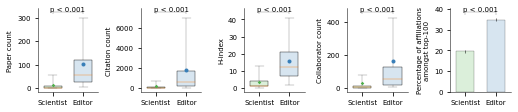

In [18]:
cm = 1/2.54  # centimeters in inches
plt.figure(figsize=(18.3*cm, 4*cm))

ax = plt.subplot(1, 5, 1)
plotBox(ax, [astats.APriorPaperCount.values, estats.EPriorPaperCount.values], 150)
        
ax.set_xticks([1, 2])
ax.set_xticklabels(['Scientist', 'Editor'])
ax.set_ylabel('Paper count')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_yticks([0, 30, 60, 90, 120, 150])
#ax.set_ylim(0, 150)
ax.set_xlim(0.5, 2.5)

ax = plt.subplot(1, 5, 2)
plotBox(ax, [astats.APriorCitationCount.values, estats.EPriorCitationCount.values], 2500)
ax.set_xticks([1, 2])
ax.set_xticklabels(['Scientist', 'Editor'])
ax.set_ylabel('Citation count')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylim(0, 2500)
ax.set_xlim(0.5, 2.5)

ax = plt.subplot(1, 5, 3)
plotBox(ax, [astats.AHindex.values, estats.EHindex.values], 22)
ax.set_xticks([1, 2])
ax.set_xticklabels(['Scientist', 'Editor'])
ax.set_ylabel('H-index')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylim(0, 22)
ax.set_xlim(0.5, 2.5)

ax = plt.subplot(1, 5, 4)
plotBox(ax, [astats.AColabCount.values, estats.EColabCount.values], 240)
ax.set_xticks([1, 2])
ax.set_xticklabels(['Scientist', 'Editor'])
ax.set_ylabel('Collaborator count')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylim(0, 240)
ax.set_xlim(0.5, 2.5)


ax = plt.subplot(1, 5, 5)
plotBar(ax, [astats.ATop.values, estats.ETop.values], 0.48, ttest=False)
ax.set_xticks([1, 2])
ax.set_xticklabels(['Scientist', 'Editor'])
ax.set_ylabel('Percentage of affiliations\namongst top-100')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
ax.set_yticklabels([0, 10, 20, 30, 40])
#ax.set_ylim(0, 0.48)
ax.set_xlim(0.5, 2.5)

plt.tight_layout()

#plt.savefig('../figures/main_1_box.pdf', bbox_inches = 'tight', pad_inches = 0)

## f, g, h, i, j, k

In [11]:
def meanCI(a, conf=0.95):
    mean, sem, m = np.mean(a), st.sem(a), st.t.ppf((1+conf)/2., len(a)-1)
    return mean, sem*1.96

In [12]:
def plot_curve(df, x, y, role, y_min, y_max, x_min, x_max, ax, window):
    df.fillna(0, inplace=True)
    meandf = pd.DataFrame()

    for year in range(x_min-window, x_max+1):
        data = df[ df[x] == year ][y].tolist()
        mid, lo, hi = mean_confidence_interval(data)
        meandf = meandf.append({x: year, 'mean': mid, 'lo': lo, 'hi': hi}, ignore_index=True)

    meandf.fillna(0, inplace=True)

    meandf['hi'] = meandf.hi.rolling(window, center=False).mean()
    meandf['lo'] = meandf.lo.rolling(window, center=False).mean()
    meandf['mean'] = meandf['mean'].rolling(window, center=False).mean()

    meandf = meandf[(meandf[x] >= x_min) & (meandf[x] <= x_max)]

    if role == 'editors':
        line, = ax.plot(meandf[x], meandf['mean'], alpha=1, color='#4daf4a', linewidth=1.2)
        ax.fill_between(meandf[x], meandf['lo'], meandf['hi'], alpha = 0.1, color='#4daf4a')
    elif role == 'authors':
        line, = ax.plot(meandf[x], meandf['mean'], alpha=1, color='#377eb8', linewidth=1.2)
        ax.fill_between(meandf[x], meandf['lo'], meandf['hi'], alpha = 0.1, color='#377eb8')
        
    ax.set_ylim([y_min, y_max])
    ax.set_xlim([x_min, x_max])

    return line

In [13]:
def plot_dots(df, outcome, ax, style, c, x_min=1980, x_max=2017):
    for year in range(x_min, x_max+1):
        sub = df[df.Year0 == year]
        v = sub[outcome].values
        
        me, sem = meanCI(v, 0.95)
        ax.errorbar(year, me, yerr=sem, color=c, fmt=style, elinewidth=0.5, ms=2)

In [14]:
def plotTemporal(ax, a, e, ylim):
    if a is not None:
        plot_dots(astats, a, ax, 'x', '#4daf4a') # author
    plot_dots(estats, e, ax, 'o', '#377eb8')
    
    ax.set_xticks([1980,1990,2000,2010])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(b=True, ls=':')
    ax.set_ylim(0, ylim)

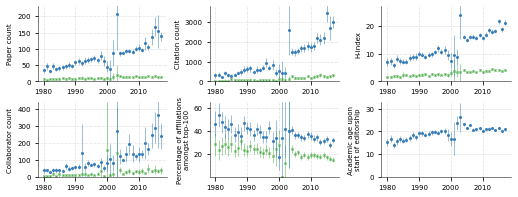

In [15]:
cm = 1/2.54  # centimeters in inches
plt.figure(figsize=(18.3*cm, 7*cm))

outcomes = [['APriorPaperCount','EPriorPaperCount'],
            ['APriorCitationCount','EPriorCitationCount'],
            ['AHindex','EHindex'],        
            ['AColabCount','EColabCount'],
           ['ATop','ETop']]

ylims = [230, 3800, 27, 440, 0.6, 28]

axes = [plt.subplot(2, 3, 1), plt.subplot(2, 3, 2), plt.subplot(2, 3, 3),
       plt.subplot(2, 3, 4), plt.subplot(2, 3, 5), plt.subplot(2, 3, 6)]

for i in range(5):
    plotTemporal(axes[i], *outcomes[i], ylims[i])
    
plotTemporal(axes[5], None, 'Age', ylims[5])
axes[5].set_ylim(0, 33)
# this is plotting standard error of mean, and not 95% CI !!!

axes[0].set_ylabel('Paper count')
axes[1].set_ylabel('Citation count')
axes[2].set_ylabel('H-index')
axes[3].set_ylabel('Collaborator count')
axes[4].set_ylabel('Percentage of affiliations\namongst top-100')
axes[5].set_ylabel('Academic age upon\nstart of editorship')

# top-100
axes[4].set_ylabel('Percentage of affiliations\namongst top-100')
axes[4].set_yticks([0.2, 0.4, 0.6])
axes[4].set_yticklabels(['20', '40', '60'])
axes[4].set_ylim(0, 0.65)

plt.tight_layout()

plt.savefig('../figures/fig_1_fghijk.pdf', bbox_inches = 'tight', pad_inches = 0)

## l

In [13]:
def fieldMean(stats):
    
    stats = stats.assign(Count=1)
    df = stats.groupby('Discipline').agg({'EPriorPaperCount':'mean','EPriorCitationCount':'mean',
                                     'ETop':'mean','Age':'mean','Count':sum}).sort_values(
        by='Count', ascending=False).reset_index().head(16)
    
    return df

In [14]:
df = fieldMean(estats.rename(columns={'Parent':'FieldOfStudyId'}))

In [15]:
df

,Discipline,EPriorPaperCount,EPriorCitationCount,ETop,Age,Count
0,Biology,142.832119,2915.671005,0.330557,22.458355,3842
1,Economics,54.556069,1105.845954,0.375723,18.595087,3460
2,Computer science,120.537748,2007.431788,0.324503,19.156291,2265
3,Physics,136.490775,1679.795203,0.381919,23.744157,1626
4,Mathematics,90.623161,1235.389635,0.404990,21.712732,1563
5,Medicine,96.059406,2054.980198,0.395278,20.239909,1313
6,Chemistry,148.949066,2311.984720,0.308149,22.915959,1178
7,Psychology,71.172448,1750.674926,0.301288,19.267592,1009
8,Political science,50.784288,656.049268,0.320905,18.006658,751
9,Engineering,100.255782,865.360544,0.322449,19.978231,735


In [16]:
cmap = LinearSegmentedColormap.from_list("", [(0, 'grey'),(0.2, 'dodgerblue'),(0.4, 'green'),(0.6, 'gold'),(1,"red")])
MIN, MAX = df.ETop.min(), df.ETop.max()
LEN=MAX-MIN

toColor = lambda x: cmap((x-MIN)/LEN)
calcSize= lambda x: (x-15)**2*12+80

df = df.assign(markerolor=df.ETop.apply(toColor))   
df = df.assign(markersize=df.Age.apply(calcSize))

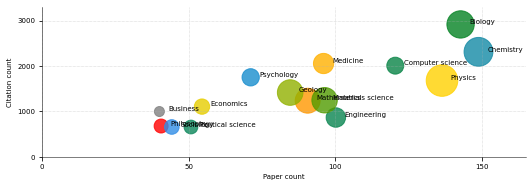

In [17]:
plt.figure(figsize=(22*cm, 7*cm))

ax = plt.gca()
ax.set_xlim(0, 165)
ax.set_ylim(0, 3300)

ax.set_yticks([0, 1000, 2000, 3000])
ax.set_xticks([0, 50, 100, 150])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(b=True, ls=':')
ax.set_xlabel('Paper count')
ax.set_ylabel('Citation count')

plt.scatter(x=df.EPriorPaperCount, y=df.EPriorCitationCount, s=df.markersize, c = df.markerolor, alpha=0.8)

for ind, row in df.iterrows():
    ax.annotate(row['Discipline'], (row['EPriorPaperCount']+3, row['EPriorCitationCount']+10))

#plt.savefig('../figures/fig_1_l.pdf', bbox_inches = 'tight', pad_inches = 0)

In [18]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

plt.figure(figsize=(8*cm, 0.1*cm))
ax = plt.gca()
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

ticks = [0.25, 0.3, 0.35, 0.4, 0.45]
pos = [(x-MIN)/LEN*256 for x in ticks]

ax.set_xticks(pos)
ax.set_xticklabels([int(x*100) for x in ticks])

[Text(1.5015897379673229, 0, '25'),
 Text(60.06358951869311, 0, '30'),
 Text(118.62558929941889, 0, '35'),
 Text(177.18758908014476, 0, '40'),
 Text(235.74958886087055, 0, '45')]

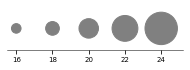

In [19]:
plt.figure(figsize=(8*cm, 2*cm))
ax = plt.gca()

xs=[16, 18, 20, 22, 24]
ax.set_xlim(15.5, 25.2)
ax.set_xticks([16, 18, 20, 22, 24])
ax.set_ylim(0, 2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])

ax.scatter(xs, [1, 1, 1, 1, 1], s=[calcSize(x) for x in xs], c='gray')